Back to the main [Index](../index.ipynb)  <a id="top"></a>

<div class="jumbotron">
  <h1 class="display-3">Temperature-dependent QP band structures</h1>
  <p class="lead">Carbon in diamond structure</p> 
  <hr class="my-4">
  <p>
In this lesson, we discuss how to compute the electron-phonon (EPH) self-energy and the renormalization of the electronic states due to EPH. We start with a very brief discussion of the basic equations and some technical details about the Abinit implementation. Then we show how to build an AbiPy flow to automate the multiple steps required by this calculation.
    </p>
<p>
In the second part, we use the AbiPy objects to analyze the results. We start from the simplest case of a single EPH calculation whose most important results are stored in the SIGEPH.nc file. Then we show how to use SigEPhRobot to handle multiple netcdf files and perform convergence studies. 
Finally, we present a possible approach to interpolate the QP corrections to obtain temperature-dependent band structures along an arbitrary high-symmetry k-path.
</p>
</div>

<div class="alert alert-info">
  <strong>Warning!</strong> 
  The code for the E-PH self-energy is still under development.
</div>

## Table of Contents
[[back to top](#top)]

* [A bit of Theory](#A-bit-of-theory-and-some-details-about-the-implementation)
* [Building a Flow for EPH self-energy calculations](#Building-a-Flow-for-EPH-self-energy-calculations)
* [Electronic properties](#Electronic-properties)
* [Vibrational properties](#Vibrational-properties)
* [E-PH self-energy](#E-PH-self-energy)
* [Using SigEphRobot for convergence studies](#Using-SigEphRobot-for-convergence-studies)
* [Convergence study with respect to nbsum and nqibz](#Convergence-study-with-respect-to-nbsum-and-nqibz)
* [Interpolating QP corrections with star functions](#Interpolating-QP-corrections-with-star-functions)



## A bit of theory and some details about the implementation
[[back to top](#top)]

$\newcommand{\kk}{{\mathbf k}}$
$\newcommand{\qq}{{\mathbf q}}$
$\newcommand{\kpq}{{\kk+\qq}}$
$\newcommand{\RR}{{\mathbf R}}$
$\newcommand{\rr}{{\mathbf r}}$
$\newcommand{\<}{\langle}$
$\renewcommand{\>}{\rangle}$
$\newcommand{\KS}{{\text{KS}}}$
$\newcommand{\ww}{\omega}$
$\newcommand{\ee}{\epsilon}$

The electron-phonon matrix elements are defined by:

\begin{equation} %\label{eq:eph_matrix_elements}
    g_{mn}^{\nu}(\kk,\qq) = \dfrac{1}{\sqrt{2\omega_{\qq\nu}}} \<\psi_{m \kpq} | \Delta_{\qq\nu} V^\KS |\psi_{n\kk}\> 
\end{equation}

where the first order variation of the KS potential is given by:

\begin{equation}
\partial_{\kappa\alpha,\qq} v^{KS} = \Bigl (
\partial_{\kappa\alpha,\qq}{v_H} + 
\partial_{\kappa\alpha,\qq}{v_{xc}} +
\partial_{\kappa\alpha,\qq}{v_{loc}}
\Bigr ) + \partial_{\kappa\alpha,\qq} V_{nl}
\end{equation}

The first term in parenthesis depends on the first order change of the density (output of the DFPT run). 
The second term derives from the non-local part of the atom-centered (pseudo)potentials
and can be easily computed without having to perform a full DFPT calculation.
Hereafter, we use the term *DFPT potential* to refer to the above expression and
the term *self-consistent DFPT potential* to indicate the contribution that depends on the DFPT density 
(the term in parenthesis).

Throughout these notes we shall use Hartree atomic units ($e = \hbar = m_e = 1$).

### EPH self-energy

The EPH self-energy consists of two terms (Fan-Migdal + Debye-Waller):

\begin{equation}
    \Sigma^{e-ph}(\ww) = \Sigma^{FM}(\ww) + \Sigma^{DW}
\end{equation}

where only the first part (FM) is frequency dependent.

The *diagonal* matrix elements of the Fan-Migdal self-energy in the KS representation are given by:

\begin{equation}
\Sigma^{FM}_{n\kk}(\ww) = \sum_{\qq\nu b} | g_{nb}^{\nu}(\kk, \qq) | ^ 2 \times 
 \Biggl [
 \dfrac{n_{\qq\nu} + f_{b\kpq}}{\ww - \ee_{b\kpq} - \ww_{\qq\nu} + i\eta} +
 \dfrac{n_{\qq\nu} + 1 - f_{b\kpq}}{\ww + \ee_{b\kpq} + \ww_{\qq\nu} + i\eta}
\Biggr ] 
\end{equation}

where $n$ ($f$) are the temperature-dependent occupation factors for phonons (electrons)
and $\eta$ is a small positive number.
These occupation factors introduce a dependence on T in the self-energy and therefore in the QP results
For the sake of simplicity, the dependence on T won't be explictly mentioned in the other equations.

TODO:
The Debye-Waller term, instead, requires ...

The QP energies are usually obtained with the approximated expression:

\begin{equation}
\ee^{QP}_{b\kk} \approx \ee^{KS}_{b\kk} + Z_{b\kk}\,\Sigma^{ep-h}(\ee^{KS}_{b\kk})
\end{equation}

where the renormalization factor $Z$ is given by:

\begin{equation}
Z_{b\kk} = \Bigl ( 1 - \Re\dfrac{\partial\Sigma^{e-ph}}{\partial{\ee_{KS}}} \Bigr )^{-1}
\end{equation}

The above expression assumes that the KS states and eigenvalues are relatively close the QP results. 
A more rigourous approach would requires solving the non linear QP equation:
in the complex plane with possibly multiple solutions.

Finally, the spectral function is given by:

\begin{equation}
A_{n\kk}(\ww) = \dfrac{1}{\pi} \dfrac
{|\Im \Sigma^{eph}_{n\kk}(\ww)|} 
{\bigl[ \ww - \ee_{n\kk} - \Re{\Sigma^{eph}_{n\kk}(\ww)} \bigr ] ^2+ \Im{\Sigma^{eph}_{n\kk}(\ww)}^2}
\end{equation}


### Interpolation of the DFPT potentials

EPH calculations require very dense BZ meshes to converge and 
the calculation of the DFPT potentials represent a significant fraction of the overall computing time.
To reduce the computational cost, Abinit employs the Fourier-based interpolation technique proposed by
Eiguren and Ambrosch-Draxl in [Phys. Rev. B 78, 045124](dx.doi.org/10.1103/PhysRevB.78.045124).

The DFPT potentials can be interpolated by introducing:

\begin{equation}
    W(\rr,\RR) = \dfrac{1}{N_\qq} \sum_\qq e^{-i\qq\cdot\RR} \partial v^{scf}_\qq(\rr)
\end{equation}

This quantity is usually short-ranged and the interpolated potential at an arbitrary point $\tilde q$
is obtained via:

\begin{equation}
    V^{scf}_{\tilde\qq}(\rr) = \sum_\RR e^{+i{\tilde \qq}\cdot\RR} W(\rr, \RR)
\end{equation}

In polar materials, particular care must be taken due to  thelong-range behavior of $W$...


## Technical details

For the previous discussion, it should be clear that the evaluation of the e-ph self-energy requires:

1. An initial set of KS wavefunctions and eigenvalues including **several empty** states

2. The knowledge of the dynamical matrix $D(\qq)$ from which one 
   can obtain frequencies and displacements everywhere in the BZ via FT interpolation.
   
3. A set of DFPT potentials in the IBZ.

Thanks to these three ingredients, the EPH code can compute the electron-phonon matrix elements
and build the self-energy matrix elements.
A schematic representation of a typical E-PH workflow is given in the figure below:

<img src="https://raw.githubusercontent.com/abinit/abipy_assets/master/eph_workflow.png" width="600" height="600">

The `mrgddb` and `mrgdv` are Fortran executables whose main goal is to *merge* the partial files
obtained at the end of a single DFPT run for given q-point and atomic perturbation
and produce the final database required by the EPH code.

Note that, for each quasi-momentum $\kk$, the self-energy $\Sigma_{n\kk}$ 
is given by an integral over the BZ.
This means that:

1. The WFK file must contain the $\kk$-points and the bands where the QP corrections are wanted as well
   as enough empty state to perform the summation over bands.
   
2. The code can (Fourier) interpolate the phonon frequencies and the DFPT potentials 
   over an arbitrarly dense q-mesh. 
   Still, for a fixed $k$-points, the code requires the ab-initio KS states at $\kk$ and $\kpq$.
   **Providing a WKF file on a k-mesh that fulfills this requirement is responsability of the user**.
   
Since we are computing the contribution to the electron self-energy due to the interaction with phonons, 
it's not surprising to encounter variables that are also used in the $GW$ code in which we compute 
the electron-electron part of the self-energy by solving Hedin's equations assuming frozen atoms.

More specifically, one can use the `nkptgw`, `kptgw`, `bdgw` variables to select
the electronic states for which the QP corrections are wanted (see also `gw_qprange`) 
and `zcut` for the complex shift.
The code can take advantage of symmetries to reduce the BZ integral to an appropriate 
irreducible wedge defined by the little group of the k-point (calculations at $\Gamma$ are therefore
much faster than for other low-symmetry k-points).

<!--
Note, in particular, how the computation of the WFK file used by the EPH calculation 
and the computation of the dynamica matrix are 
This means that one could perform the DFPT section with a relatively coarse k-mesh and q-mesh,
compute another WFK file with a much denser k-mesh and use the interpolation..
-->

## Suggested references
[[back to top](#top)]

You might find additional material, related to the present section, in the following references: 

## Building a Flow for EPH self-energy calculations
[[back to top](#top)]

Before starting, we need to import the python modules used in this notebook:

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
abilab.enable_notebook() # This line tells AbiPy we are running inside a notebook
import abipy.flowtk as flowtk

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

and a function from the `lesson_sigeph` module that will build our AbiPy flow.

In [3]:
from lesson_sigeph import build_flow

<div class="alert alert-info" role="alert">
Please read the code carefully, in particular the comments.
Don't worry if the meaning of some input variables is not immediately clear
as we will try to clarify the most technical parts in the rest of this notebook.
</div>

In [4]:
abilab.print_source(build_flow)

OK the function is a little bit long but it's normal as we are computing
in a single workflow the *electronic* properties, the *vibrational* spectrum 
and the *electron-phonon* self-energy by varying the number of q-points and the 
number of empty states.
Note that we have already encountered similar flows in the previous AbiPy lessons. 
The calculation of electronic band structures is
discussed in 
[lesson_base3](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/base3/lesson_base3.ipynb),
an example of `Flow` for phonon calculations is given in 
[lesson_dfpt](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/dfpt/lesson_dfpt.ipynb).
An AbiPy flow for the computation of $G_0W_0$ corrections is discussed in
[lesson_gw0](https://nbviewer.jupyter.org/github/abinit/abitutorials/blob/master/abitutorials/g0w0/lesson_g0w0.ipynb).

The novelty is represented by the generation of the `EphTasks` 
in which we have to specify several variables related to phonons and the EPH self-energy.
For your convenience, we have grouped the variables used in the `EphTask` in sub-groups:

<img src="https://github.com/abinit/abipy_assets/blob/master/eph_variables.png?raw=true">

Hopefully things will become clearer if we build the flow and start to play with it:

In [8]:
#abilab.docvar("eph_ngqpt_fine")

In [5]:
flow = build_flow(options=None)
flow.show_info()

<Flow, node_id=312940, workdir=flow_diamond>
Number of works: 4, total number of tasks: 23
Number of tasks with a given class:

Task Class      Number
------------  --------
ScfTask              1
NscfTask             2
PhononTask          14
EphTask              6

We now print the input of the last `EphTask`. 
Please read carefully the documentation of the variables, in particular 
those in the `vargw`, `varrf` and `vareph` sections.



In [6]:
print(flow[-1][-1])
flow[-1][-1].input

<EphTask, node_id=312976, workdir=flow_diamond/w3/t2>


<AbinitInput at 4759103080>

<div class="alert alert-info" role="alert">
The input does not contain any `irdwfk` or `getwfk` variable. AbiPy will add the required `ird*` 
variables at runtime and create symbolic links to connect this task to its parents.
</div>

As usual, it's much easier to understand what's happening if we plot a graph
with the individual tasks and their connections.
Since there are several nodes in our graph, we first focus on the EPH part 
and then we "zoom-out" to unveil the entire workflow.
Let's have a look at the parents of the last `EphTask` with:

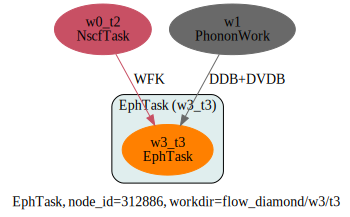

In [131]:
flow[-1][-1].get_graphviz()

The graph shows that the `EphTask` uses the `WFK` produced by a NSCF calculation 
as well as two other files generated by the `PhononWork`. 
If this is not the first time you run DFPT calculations with Abinit, you already know that the `DDB`
is essentially a text file with the independent entries of the dynamical matrix.
This file is usually produced by merging partial `DDB` files with the `mrgddb` utility.
For further information about the `DDB` see [this notebook](../ddb.ipynb).

The `DVDB`, on the other hand, is a Fortran binary file containing an independent set
of DFPT potentials (actually the first-order variation of the self-consistent DFPT potential
due to an atomic perturbation characterized by a q-point and the [`idir, ipert`] pair).
The `DVDB` is generated by merging the `POT` files produced at the end of the DFPT run
with the `mrgdv` tool.

Now let's turn our attention to the last `Work`:

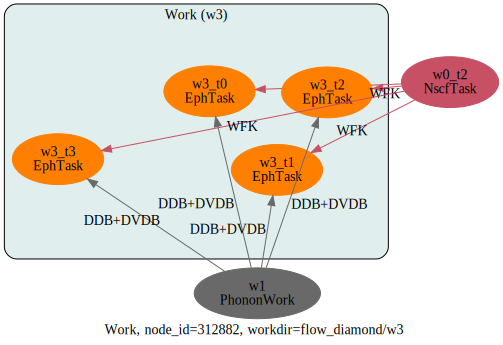

In [132]:
flow[-1].get_graphviz()

As you can see, this section of the `flow` consists of four `EphTasks`, all with the same parents.
This is the part that computes the EPH self-energy with a fixed q-mesh and different values of `nband`.
We can easily check this with:

In [133]:
print("nband:", [task.input["nband"] for task in flow[-1]])
print("q-mesh for self-energy:", [task.input["eph_ngqpt_fine"] for task in flow[-1]])

nband: [25, 50, 75, 100]
q-mesh for self-energy: [[8, 8, 8], [8, 8, 8], [8, 8, 8], [8, 8, 8]]


or, alternatvely, we select the last work and call `get_vars_dataframe` with the list of variable names:

In [134]:
flow[-1].get_vars_dataframe("nband", "eph_ngqpt_fine")

,nband,eph_ngqpt_fine
w3_t0,25,"[8, 8, 8]"
w3_t1,50,"[8, 8, 8]"
w3_t2,75,"[8, 8, 8]"
w3_t3,100,"[8, 8, 8]"


There's another `work` made of `EphTasks` with similar organization, the only difference being
that we use the ab-initio q-mesh for the DFPT potentials (no Fourier interpolation here). 

In [135]:
print("nband:", [task.input["nband"] for task in flow[-2]])
print("q-mesh for self-energy:", [task.input["eph_ngqpt_fine"] for task in flow[-2]])

nband: [25, 50, 75, 100]
q-mesh for self-energy: [[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4]]


In [136]:
flow[-2].get_vars_dataframe("nband", "eph_ngqpt_fine")

,nband,eph_ngqpt_fine
w2_t0,25,"[4, 4, 4]"
w2_t1,50,"[4, 4, 4]"
w2_t2,75,"[4, 4, 4]"
w2_t3,100,"[4, 4, 4]"


At this point, we should have a good understanding of the input files required by the `EphTasks`.
There's only one point missing! How do we get the `WFK`, `DDB`, `DVDB` files?

Well, in the old days we used to write several input files one for each q-point in the IBZ, link files 
and merge the intermediate results manually but now we can use python to automate the entire procedure:

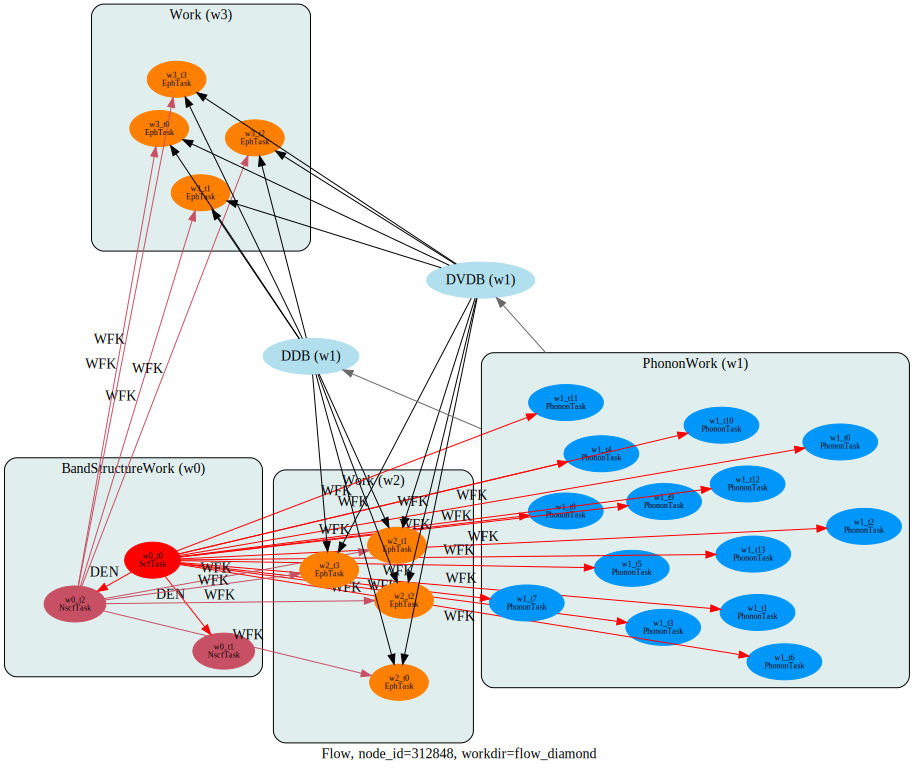

In [137]:
flow.get_graphviz()

<!-- Note that the q-mesh for the self-energy is denser than the *ab-initio* one used for the DFPT run.
This means that the code will activate the Fourier interpolation of the DFPT potentials.
Note that the k-mesh and the q-mesh cannot be arbitrary. 
-->

<div class="alert alert-info" role="alert">
Remember that the $q$-point mesh cannot be chosen arbitrarily
since all $q$ wavevectors should connect two $k$ points of the grid used for the electrons.

More specifically, the q-mesh associated to the 
`DDB` (`DVDB`) must be a submesh of the k-mesh for electrons.
Moreover the EPH code can compute self-energy corrections only for the states that are available in the `WFK` file.
</div>

Now we can generate the directories and the input files of the `Flow` by executing the 
lesson_sigeph.py script that will generate the flow_diamond directory with all the input 
files required by the calculation.

Then use the `abirun.py` script to launch the entire calculation:

    abirun.py flow_diamond scheduler
    
You may want to run this example in the terminal if you've already installed and configured AbiPy and Abinit
on your machine.
The calculation requires ~8 minutes on a poor 1.7 GHz Intel Core i5 (2 minutes for all the EPH tasks,
the rest for the DFPT section)

If you prefer to skip this part, jump to next section in which we focus on the post-processing of the results.
Note that the output files are already available in the [github repository](https://github.com/abinit/abitutorials)
so it's possible to try the AbiPy post-processing tools without having to run the flow.
In particular, one can use the command line and the commands:

    abiopen.py FILE
    
to open the file inside ipython,

    abiview.py sigeph out_SIGEPH.nc
    
to visualize the self-energy results and finally,

    abicomp.py sigeph flow_diamond/w3/
    
 to compare multiple `SIGEPH.nc` files with the robot inside ipython.

## Electronic properties
[[back to top](#top)]

Let's focus on the electronic properties first.

In [285]:
!find flow_diamond/ -name "out_GSR.nc"

flow_diamond//w0/t0/outdata/out_GSR.nc
flow_diamond//w0/t1/outdata/out_GSR.nc
flow_diamond//w0/t2/outdata/out_GSR.nc


The task `w0/t0` computed the electronic band structure on a high-symmetry k-path.
Let's plot the bands with:

<IPython.core.display.Javascript object>


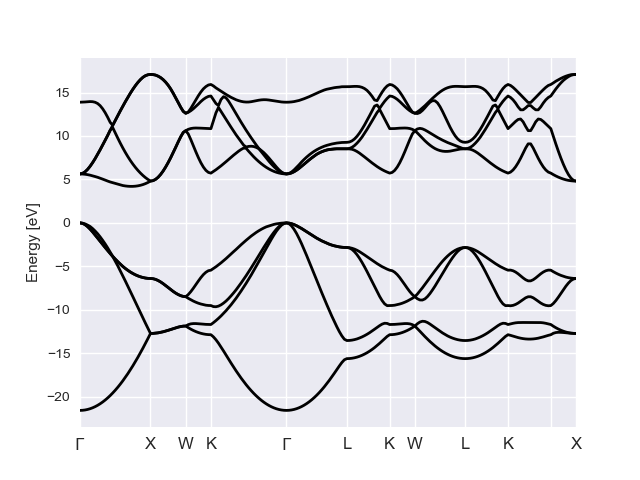

In [286]:
with abilab.abiopen("flow_diamond/w0/t1/outdata/out_GSR.nc") as gsr:
    ebands_kpath = gsr.ebands
    
ebands_kpath.plot();

It's not surprising to see that diamond is a indirect gap semiconductor. 
The KS band structure gives a direct gap at $\Gamma$ of ~5.6 eV while the fundamental gap 
is ~4.2 eV (VBM at $\Gamma$, CBM at ~[+0.357, +0.000, +0.357] in reduced coordinates).
These values have been obtained by ApiPy on the basis of the k-path used to computed to band structure
in the `NscfTask`:

In [287]:
print(ebands_kpath)

================================= Structure =================================
Full Formula (C2)
Reduced Formula: C
abc   :   2.508336   2.508336   2.508336
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  C     0     0     0
  1  C     0.25  0.25  0.25

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

Number of electrons: 8.0, Fermi level: 12.773 [eV]
nsppol: 1, nkpt: 198, mband: 8, nspinor: 1, nspden: 1
smearing scheme: none, tsmear_eV: 0.272, occopt: 1
Direct gap:
    Energy: 5.634 [eV]
    Initial state: spin=0, kpt=[+0.000, +0.000, +0.000], name: $\Gamma$, weight: 0.000, band=3, eig=12.773, occ=2.000
    Final state:   spin=0, kpt=[+0.000, +0.000, +0.000], name: $\Gamma$, weight: 0.000, band=4, eig=18.407, occ=0.000
Fundamental gap:
    Energy: 4.203 [eV]
    Initial state: spin=0, kpt=[+0.000, +0.000, +0.000], name: $\Gamma$, weight: 0.000, band=3, eig=12.773, occ=2.000
  

In the `NscfTask` `w0/t2` we have computed the KS eigenstates including several empty states. 
This is the `WFK` file we are going to use to build the `EPH` self-energy.

Let's plot the bands in the IBz and the associated DOS with:

<IPython.core.display.Javascript object>


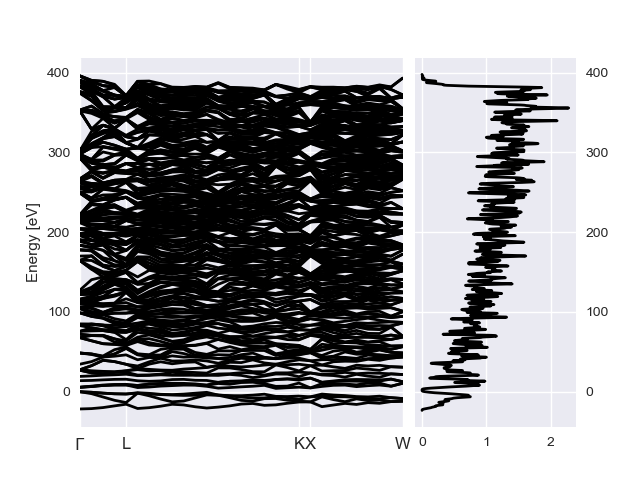

In [288]:
with abilab.abiopen("flow_diamond/w0/t2/outdata/out_GSR.nc") as gsr:
    ebands_4sigma = gsr.ebands

# 8x8x8 is too coarse to get nice DOS so we increase the gaussian smearing
# (we are essentially interested in the possible presence of ghost states --> sharp peaks) 
ebands_4sigma.plot_with_edos(ebands_4sigma.get_edos(width=0.6));

The figure shows that our value of `nband` correspond to ~400 eV above the VBM.

Note that it's' always a good idea to look at the behaviour of the high-energy states
when running self-energy calculations, especially the first time you use a new pseudopotential 

**Ghost states**, indeed, can appear somewhere in the high-energy region causing sharp peaks in the DOS.
The presence of these high-energy ghosts is not clearly seen in standard GS calculations 
but they can have drammatic consequences 
for many-body calculations based on sum over states approaches.
This is one of the reasons why the pseudopotentials provided by the [pseudo-dojo project](http://www.pseudo-dojo.org/)
have been explictly tested for the presence of ghost states in the empty region
(see [here](https://www.sciencedirect.com/science/article/pii/S0010465518300250?via%3Dihub) for further details)

## Vibrational properties
[[back to top](#top)]

Now we turn our attention to the vibrational properties.
AbiPy has already merged all the independent atomic perturbations in `flow_diamond/w1/outdata/out_DDB`:

In [289]:
!find flow_diamond/ -name "out_DDB"

flow_diamond//w0/t0/outdata/out_DDB
flow_diamond//w1/outdata/out_DDB


This the input file for `mrgddb` produced automatically by python:

In [290]:
!cat flow_diamond//w1/outdata/mrgddb.stdin

/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/outdata/out_DDB
DDB file merged by PhononWork on Sat Mar 17 17:03:21 2018
14
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t0/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t1/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t2/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t3/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t4/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t5/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t6/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t7/outdata/out_DDB
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t8/outdata/out_DDB
/Users/gmatt

The first line gives the name of the output DDB file followed by a title, the number of partial DDB files
we want to merge and their path.

A similar input file must be provided to `mrgdv`, the only difference is that DDB files are not replaced 
by `POT*` files with the SCF part of the DFTP potential:

In [291]:
!find flow_diamond/ -name "out_DVDB"

flow_diamond//w1/outdata/out_DVDB


In [292]:
!cat flow_diamond//w1/outdata/mrgdvdb.stdin

/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/outdata/out_DVDB
14
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t0/outdata/out_POT1
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t1/outdata/out_POT1
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t2/outdata/out_POT2
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t3/outdata/out_POT1
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t4/outdata/out_POT2
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t5/outdata/out_POT1
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t6/outdata/out_POT1
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t7/outdata/out_POT2
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/t8/outdata/out_POT3
/Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/fl

Let's open the `DDB` file with:

In [293]:
ddb = abilab.abiopen("flow_diamond/w1/outdata/out_DDB")
print(ddb)

================================= File Info =================================
Name: out_DDB
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w1/outdata
Size: 55.08 kb
Access Time: Sat Mar 17 17:08:27 2018
Modification Time: Sat Mar 17 17:03:21 2018
Change Time: Sat Mar 17 17:03:21 2018

================================= Structure =================================
Full Formula (C2)
Reduced Formula: C
abc   :   2.508336   2.508336   2.508336
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  C     0     0     0
  1  C     0.25  0.25  0.25

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

================================== DDB Info ==================================

Number of q-points in DDB: 8
guessed_ngqpt: [4 4 4] (guess for the q-mesh divisions made by AbiPy)
Has electric-field perturbation: False
Has Born effective charges: True


and then invoke `anaddb` to compute phonon bands and DOS:

In [294]:
phbst, phdos = ddb.anaget_phbst_and_phdos_files()

Finally we plot the results with:

<IPython.core.display.Javascript object>


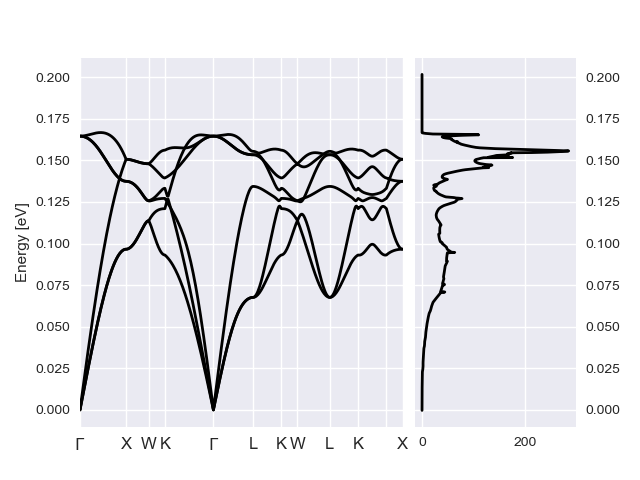

In [295]:
phbst.phbands.plot_with_phdos(phdos);

The maximum phonon frequency is ~0.17 eV that is much smaller that the KS fundamental gap.
This means that at T=0 we cannot have scattering processes 
between two electronic states in which only one phonon is involved. 
This however does not mean that the electronic properties won't be renormalized by EPH interaction, even at T=0
(zero-point motion effect).

<!-- The scenario would be completely different if we had a semiconductors with an energy gap comparable 
to phonon energies or a semimetallic system.
<div class="alert alert-warning">
There are instabilities around the $\Gamma$ point but this is essentialy due to the use of underconverged parameters.
We decided to work with a small cutoff energy to keep the calculation manageable. In real life, one should
increase `ecut` and re-run the DFPT part.
</div>
-->


So far, we managed to generate a `WFK` with empty states on s 8x8x8 k-mesh, 
and a pair of `DDB`-`DVDB` files on a 4x4x4 q-mesh.
We can now finally turn our attention to the EPH self-energy.

## E-PH self-energy
[[back to top](#top)]

Let's focus on the output files produced by the first `EphTask` in `w2/t0`:

In [296]:
!ls flow_diamond/w2/t0/outdata

out_EBANDS.agr    out_PHBST.nc      out_PHDOS_by_atom out_THERMO
out_OUT.nc        out_PHDOS         out_PHDOS_msqd
out_PHBANDS.agr   out_PHDOS.nc      out_SIGEPH.nc


where:
    
* *out_PHBST.nc*: phonon band structure along the q-path
* *out_PHDOS.nc*: phonon DOS and projections over atoms and directions
* *out_SIGEPH.nc*: $\Sigma^{eph}_{nk\sigma}(T)$ matrix elements for different temperatures $T$

There are several physical properties stored in the `SIGEPH` file.
As usual, we can use `abiopen` to open the file and and `print(abifile)`  get a quick summary 
of the most important results:

In [297]:
#sigeph = abilab.abiopen("flow_diamond/w2/t0/outdata/out_SIGEPH.nc")
sigeph = abilab.abiopen("flow_diamond/w3/t2/outdata/out_SIGEPH.nc")
print(sigeph)

================================= File Info =================================
Name: out_SIGEPH.nc
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/sigeph/flow_diamond/w3/t2/outdata
Size: 308.77 kb
Access Time: Sat Mar 17 17:08:36 2018
Modification Time: Sat Mar 17 17:04:39 2018
Change Time: Sat Mar 17 17:04:39 2018

================================= Structure =================================
Full Formula (C2)
Reduced Formula: C
abc   :   2.508336   2.508336   2.508336
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  C     0     0     0
  1  C     0.25  0.25  0.25

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

============================ KS Electronic Bands ============================
Number of electrons: 8.0, Fermi level: 14.875 [eV]
nsppol: 1, nkpt: 29, mband: 210, nspinor: 1, nspden: 1
smearing scheme: none, tsmear_eV: 0.272, occopt: 1
Direct gap:
    Energy:

In [298]:
#sigeph.get_dataframe_sk(0, 0)

The output reveals that the direct QP gaps are smaller 
than the corresponding KS values, even at $T=0$.
Still it's difficult to understand what's happening without a *graphical* rapresentation of the results.
Let's use matplotlib to plot the KS and the QP energies in the IBZ with:

<IPython.core.display.Javascript object>


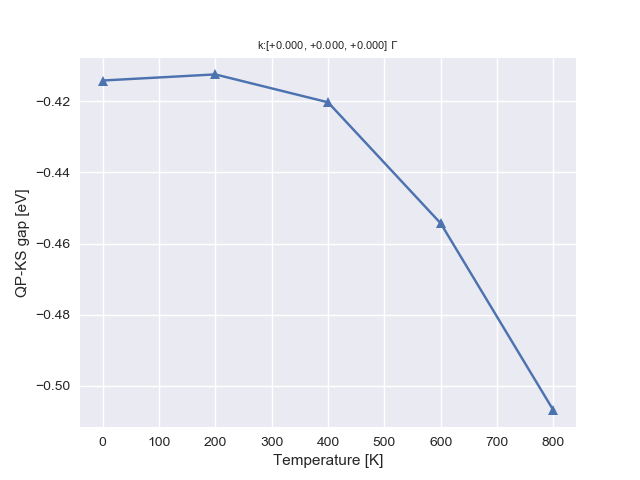

In [299]:
sigeph.plot_qpgaps_t(); #qp_kpoints=[0, 1]);

It's clear from the figure that, in diamond, the EPH interaction at T=0 tends to decrease the direct gaps with respect 
to the KS value.
The effect of the temperature, however, is not evident on this scale.
Perhaps it's much better if we plot the *difference* between the QP and the KS direct gaps 
as a function of T for the first two k-points:

In [300]:
#sigeph.plot_qpbands_ibzt();

<IPython.core.display.Javascript object>


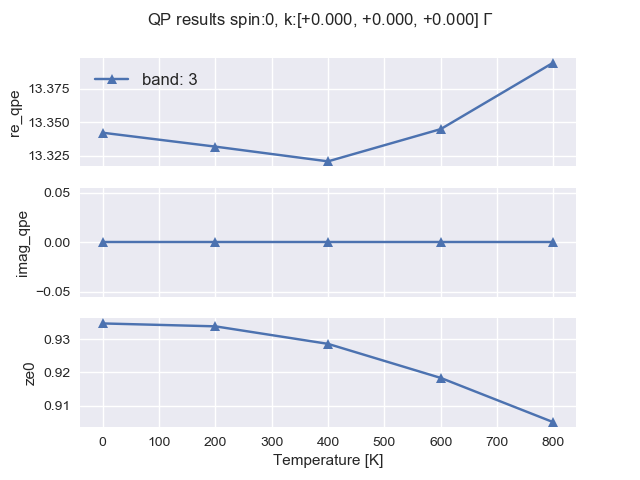

In [301]:
sigeph.plot_qpdata_t(spin=0, kpoint=0, band_list=[3]); #qp_kpoints=[0, 1]);

<IPython.core.display.Javascript object>


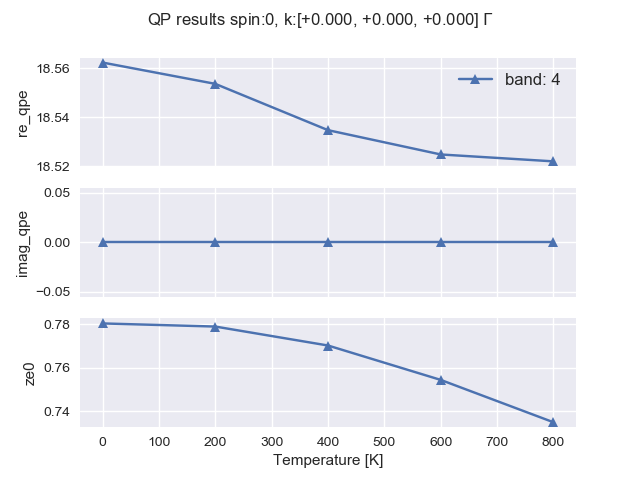

In [302]:
sigeph.plot_qpdata_t(spin=0, kpoint=0, band_list=[4]); #qp_kpoints=[0, 1]);

The effect of T with the convergence parameters is small, still it is clear from the figures 
that the self-energy tends to decrease the direct gap with respect to the KS results.
This results, however, cannot be generalized in the sense that there are systems 
in which the direct gap *increases* with T.

In [303]:
#So far we have been focusing on the QP direct gaps but we can also look 
#at the QP results  for the other bands. 
#In this case, it's quite useful to plot the QP results as a function of the KS energy:
#sigeph.plot_qps_vs_e0();

We can also plot the real and the imaginary part of $\Sigma_{nk}^{eph}(\omega)$ 
and the spectral function $A_{nk}(\omega)$ obtained for the different temperatures with:

<IPython.core.display.Javascript object>


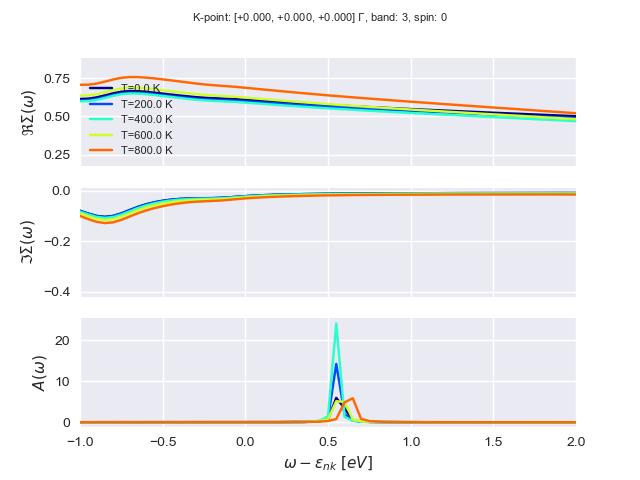

In [304]:
sigma = sigeph.get_sigeph_skb(spin=0, kpoint=[0, 0, 0], band=3)
sigma.plot_tdep(xlims=[-1, 2]);

<IPython.core.display.Javascript object>


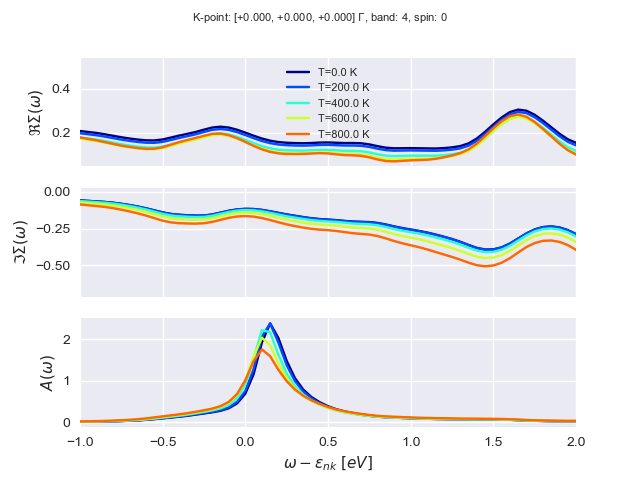

In [305]:
sigeph.get_sigeph_skb(spin=0, kpoint=[0, 0, 0], band=4).plot_tdep(xlims=(-1, 2));

Converging these quantities is not an easy task since they are very sensitive to the q-point sampling.
Still, we can see that the spectral function has a dominant peak that is shifted with respect 
to the initial KS energy.


In some cases, we need to access the raw data. 
For example we may want to build a table with the QP results for all bands at fixed k-point, spin.
The code below creates a pandas `DataFrame` and selects only the entries at 5 K.

In [306]:
#df = sigeph.get_dataframe_sk(spin=0, kpoint=[0, 0, 0], ignore_imag=True)
#df[df["tmesh"] == 0.0]

## Using SigEphRobot for convergence studies
[[back to top](#top)]

Our initial goal was to analyze the convergence of the QP corrections as a function of `nbsum`.
This means we should now collect multiple `SIGEPH.nc` files, extract the data,
order the results and visualize them.
Fortunately, we can use the `SigEphRobot` (or the abicomp.py script) 
to automate the most boring and repetitive operations.

The code below, for istance, tells our robot to open all the `SIGEPH` files 
located within `flow_diamond/w2` (fixed q-mesh, different `nband`).
The syntax used to specify multiple directories should be familiar to Linux users:

In [307]:
robot_bsum = abilab.SigEPhRobot.from_dir_glob("flow_diamond/w2/t*/outdata/")
robot_bsum

Label                                     Relpath
----------------------------------------  ----------------------------------------
flow_diamond/w2/t0/outdata/out_SIGEPH.nc  flow_diamond/w2/t0/outdata/out_SIGEPH.nc
flow_diamond/w2/t1/outdata/out_SIGEPH.nc  flow_diamond/w2/t1/outdata/out_SIGEPH.nc
flow_diamond/w2/t2/outdata/out_SIGEPH.nc  flow_diamond/w2/t2/outdata/out_SIGEPH.nc

Let's change the labels of the files by replacing file paths with strings constructed
from `nbsum`:

In [308]:
robot_bsum.remap_labels(lambda sigeph: "nbsum: %d" % sigeph.nbsum)

OrderedDict([('nbsum: 100', 'flow_diamond/w2/t0/outdata/out_SIGEPH.nc'),
             ('nbsum: 150', 'flow_diamond/w2/t1/outdata/out_SIGEPH.nc'),
             ('nbsum: 200', 'flow_diamond/w2/t2/outdata/out_SIGEPH.nc')])

and check that everything is OK by printing the convergence parameters: 

In [309]:
robot_bsum.get_params_dataframe()

,nbsum,zcut,symsigma,nqbz,nqibz,ddb_nqbz,eph_nqbz_fine,ph_nqbz,eph_intmeth,eph_fsewin,eph_fsmear,eph_extrael,eph_fermie
nbsum: 100,100,0.007349865079592465,1,64,8,64,64,4096,2,0.04,0.01,0.0,0.0
nbsum: 150,150,0.007349865079592465,1,64,8,64,64,4096,2,0.04,0.01,0.0,0.0
nbsum: 200,200,0.007349865079592465,1,64,8,64,64,4096,2,0.04,0.01,0.0,0.0


As expected, the only parameter that is changing in this set of netcdf files is `nbsum`.
Now all the files are in memory and we can start our convergence study.

<div class="alert alert-success" role="alert">
There are several quantities that depend on T thus complicating a bit the analysis.
So we use the `itemp` index to select the first temperature. 
</div>

To plot the convergence of QP gaps vs the `nbsum` parameter, we use:

<IPython.core.display.Javascript object>


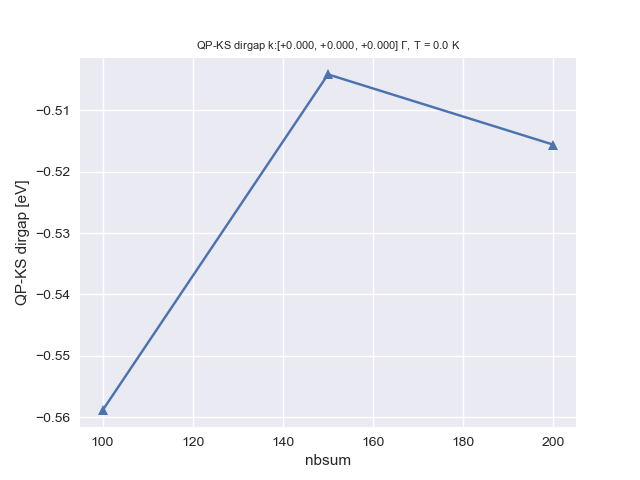

In [310]:
robot_bsum.plot_qpgaps_convergence(sortby="nbsum", itemp=0);

The results are clearly unconverged, most importantly the QP gaps 
are not variational as a function of the number of bands so we should 
always monitor the dependence of our results wrt `nband`.

In [311]:
#We can also look at the convergence of the QP gaps as a function of temperature:
#robot_bsum.plot_qpgaps_t();

We can also analyze the convergence of the individual QP terms for given $(\sigma, {\bf{k}}, n)$ with:

<IPython.core.display.Javascript object>


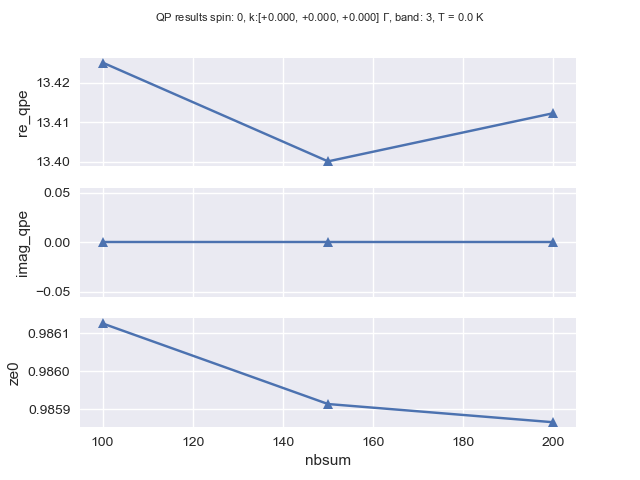

In [312]:
robot_bsum.plot_qpdata_conv_skb(spin=0, kpoint=(0, 0, 0), band=3, sortby="nbsum");

Note how the largest variations are observed in the real part of the self-energy 
while the imaginary part is rather insensitive to the number of empty states.
Also note how the QP gaps (energy differences) tend to converge much faster that the absolute values.
A similar behaviour is observed in $GW$ calculations as well.

In [313]:
#robot_bsum.plot_qpdata_conv_skb(spin=0, kpoint=(0, 0, 0), band=4, sortby="nbsum");

We can finally perform a similar analysis for $\Sigma^{eph}_{n{\bf k}}(\omega)$ 
and the spectral function $A_{n{\bf k}}(\omega)$:

In [314]:
#robot_bsum.plot_selfenergy_conv(spin=0, kpoint=(0 , 0, 0), band=4, itemp=0);

## Convergence study with respect to nbsum and nqibz
[[back to top](#top)]

In the previous section, we've analyzed the convergence of the QP results as a function of `nbsum` 
for a fixed q-point mesh.
The main conclusion was that the convergence with respect to the number of bands is slow
and that even 200 bands are not enough to converge the QP gap with a 4x4x4 q-point mesh.

Here we use *all* the `SIGEPH.nc` files produced by the `flow` to study 
how the final results depend on `nbsum` and `nqibz`.

The main goal is to understand if these two parameters are correlated or not.
In other words we want to understand if we really need to perform a convergence study in which
both parameters are increased or if we can assume some sort of *weak correlation* that allows 
us to *decouple* the two convergence studies.

Let's start by loading all the `SIGPEH.nc` files located inside `flow_diamond` with:

In [315]:
robot_qb = abilab.SigEPhRobot.from_dir("flow_diamond")
robot_qb

Label                        Relpath
---------------------------  ----------------------------------------
w2/t0/outdata/out_SIGEPH.nc  flow_diamond/w2/t0/outdata/out_SIGEPH.nc
w2/t1/outdata/out_SIGEPH.nc  flow_diamond/w2/t1/outdata/out_SIGEPH.nc
w2/t2/outdata/out_SIGEPH.nc  flow_diamond/w2/t2/outdata/out_SIGEPH.nc
w3/t0/outdata/out_SIGEPH.nc  flow_diamond/w3/t0/outdata/out_SIGEPH.nc
w3/t1/outdata/out_SIGEPH.nc  flow_diamond/w3/t1/outdata/out_SIGEPH.nc
w3/t2/outdata/out_SIGEPH.nc  flow_diamond/w3/t2/outdata/out_SIGEPH.nc

and replace the labels with:

In [316]:
robot_qb.remap_labels(lambda sigeph: "nbsum: %d, nqibz: %d" % (sigeph.nbsum, sigeph.nqibz))

OrderedDict([('nbsum: 100, nqibz: 8', 'w2/t0/outdata/out_SIGEPH.nc'),
             ('nbsum: 150, nqibz: 8', 'w2/t1/outdata/out_SIGEPH.nc'),
             ('nbsum: 200, nqibz: 8', 'w2/t2/outdata/out_SIGEPH.nc'),
             ('nbsum: 100, nqibz: 29', 'w3/t0/outdata/out_SIGEPH.nc'),
             ('nbsum: 150, nqibz: 29', 'w3/t1/outdata/out_SIGEPH.nc'),
             ('nbsum: 200, nqibz: 29', 'w3/t2/outdata/out_SIGEPH.nc')])

All the calculations in `w2` are done with a 4x4x4 q-mesh, while in `w3` we have EPH calculations
done with a 8x8x8. 
Let's print a table with the parameters of the run, just to be sure...

In [317]:
robot_qb.get_params_dataframe()

,nbsum,zcut,symsigma,nqbz,nqibz,ddb_nqbz,eph_nqbz_fine,ph_nqbz,eph_intmeth,eph_fsewin,eph_fsmear,eph_extrael,eph_fermie
"nbsum: 100, nqibz: 8",100,0.007349865079592465,1,64,8,64,64,4096,2,0.04,0.01,0.0,0.0
"nbsum: 150, nqibz: 8",150,0.007349865079592465,1,64,8,64,64,4096,2,0.04,0.01,0.0,0.0
"nbsum: 200, nqibz: 8",200,0.007349865079592465,1,64,8,64,64,4096,2,0.04,0.01,0.0,0.0
"nbsum: 100, nqibz: 29",100,0.007349865079592465,1,512,29,64,512,4096,2,0.04,0.01,0.0,0.0
"nbsum: 150, nqibz: 29",150,0.007349865079592465,1,512,29,64,512,4096,2,0.04,0.01,0.0,0.0
"nbsum: 200, nqibz: 29",200,0.007349865079592465,1,512,29,64,512,4096,2,0.04,0.01,0.0,0.0


We can start to analyze the data but there's a small problem because, strictly speaking,
we are dealing with a function of two variables. (`nbsum` and `nqibz`).
Let's analyze the converge of the QP direct gap as a function of `nbsum` and use the `hue` argument
to group results obtained with different q-meshes:

<IPython.core.display.Javascript object>


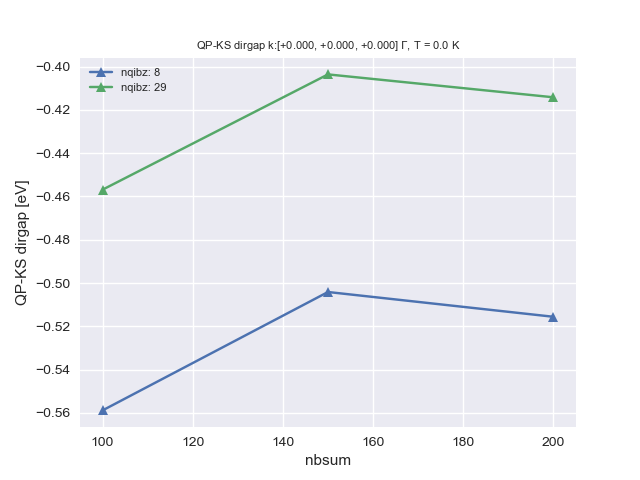

In [318]:
robot_qb.plot_qpgaps_convergence(sortby="nbsum", hue="nqibz", itemp=0);

In [258]:
#robot_qb.plot_qpgaps_convergence(plot_qpmks=False, sortby="nbsum", hue="nqibz", itemp=0);

The figure above indicates that the largest variation is due to the q-point sampling whereas
the convergence wrt to the number of empty states becomes smoother provided that *enough* bands
are included in the calculation.
This suggests that one could simplify considerably the convergence study by decoupling the two parameters.
In particular, one could perform an initial convergence study with respect to `nbsum` with a relatively coarse q-mesh
to find a reasonable value then *fix* `nbsum` and move to the convergence study wrt the q-point sampling
and the broadening.

At this point we could plot several other quantities but we prefer to leave it as an useful exercise.
We complete this section by plotting the QP-KS energy difference as a function of the KS energy:

In [281]:
#robot_qb.plot_qpfield_vs_e0("qpeme0", itemp=0, sortby="nbsum", hue="nqibz");

In [260]:
#robot_qb.plot_qpdata_conv_skb(spin=0, kpoint=(0, 0, 0), band=3, sortby="nbsum", hue="nqibz");

In [261]:
#robot_qb.plot_selfenergy_conv(spin=0, kpoint=(0.5, 0, 0), band=4, itemp=0, sortby="nbsum", hue="nqibz");

In [123]:
#robot_qb.plot_qpgaps_t(); #sortby="nbsum", plot_qpmks=True, hue="nqibz");

In [124]:
#robot_qb.plot_qpgaps_t(sortby="nbsum", plot_qpmks=True, hue="nqibz");

In [125]:
#robot_qb.plot_qpgaps_convergence(itemp=0, sortby="nbsum", hue="nqibz");

In [126]:
#robot_qb.plot_qpfield_vs_e0("ze0", itemp=0, sortby="nbsum", hue="nqibz");

## Interpolating QP corrections with star-functions
[[back to top](#top)]

In the previous paragraphs, we discussed how to compute the QP corrections as function of $T$ 
for a set of k-points in the IBZ. 
In many cases, however, we would like to visualize the effect of the self-energy 
on the *electronic dispersion* using a high-symmetry k-path.
There are several routes to address this problem.

The most accurate method would be performing multiple self-energy calculations 
with different shifted k-meshes so as to sample the high-symmetry k-path 
and then merging the results.
Alternatively, one could try to *interpolate* the QP energies obtained in the IBZ.

It's worth noting that the QP energies must fulfill the symmetry properties of the point group of the crystal:

\begin{equation}
\epsilon({\bf k + G}) = \epsilon({\bf k})
\end{equation}

and 

\begin{equation}
\epsilon(\mathcal O {\bf k }) = \epsilon({\bf k})
\end{equation}

where $\bf{G}$ is a reciprocal lattice vector and $\mathcal{O}$ is an operation of the point group.

Therefore it's possible to employ the star-function interpolation by Shankland, Koelling and Wood
in the improved version proposed by [Pickett](http://dx.doi.org/10.1103/physrevb.38.2721)
to fit the ab-initio results.
This interpolation technique, by construction, passes through the initial points and 
satisfies the basic symmetry property of the band energies.

It should be stressed, however, that this Fourier-based method can have problems in the presence of band crossings 
that may cause unphysical oscillations between the ab-initio points.
To reduce this spurious effect, we prefer to interpolate the QP corrections instead of the QP energies.
The corrections, indeed, are usually smoother in k-space and the resulting fit is more stable.

As a matter of fact we only need to pass a KS band structure to the `interpolate` method:

In [55]:
with abilab.abiopen("flow_diamond/w0/t1/outdata/out_GSR.nc") as gsr:
    ks_ebands_kpath = gsr.ebands

with abilab.abiopen("flow_diamond/w3/t3/outdata/out_SIGEPH.nc") as sigeph_w3t3:
    tdep = sigeph_w3t3.interpolate(ks_ebands_kpath=ks_ebands_kpath, itemp_list=[0, -1])

ValueError: QP energies should be computed for all k-points in the IBZ but nkibz != nkptgw

<div class="alert alert-warning">
The small value of the MAE indicates that the fit passes through the ab-initio points (as expected).
This, however, does not exclude the possibility of unphysical oscillations between the input data points
</div>

Now we can compare the interpolated QP bands with the KS results with:

In [ ]:
tdep.plot();

Let's zoom in on the region around the gap:

In [ ]:
tdep.plot(ylims=(-1, 6));

To plot the bands on the same figure:

In [ ]:
plotter = tdep.get_ebands_plotter()
plotter.combiplot();

In [ ]:
#tdep.qp_ebands_kpath_t[0].plot();

In [ ]:
#tdep.qp_ebands_kpath_t[0].plot_lws_vs_e0()
#tdep.plot_lws_vs_e0();

In [ ]:
#plotter.animate(interval=500)

In [ ]:
#with abilab.abiopen("flow_diamond/w3/t3/outdata/out_SIGEPH.nc") as sigeph_w3t3:
#    tdep_nopath = sigeph_w3t3.interpolate(itemp_list=[0, -1])
    
#tdep_nopath.plot();

## Exercises
[[back to top](#top)]

    
* Converge the $GW$ gap of ZnO, then include the EPH self-energy.

Back to the main [Index](../index.ipynb)